# Identify Camera Trap Arrays With all sites within 5km 

In [1]:
import pandas as pd 
import numpy as np 
import warnings 
from tabulate import tabulate
from itertools import combinations
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings('ignore')

In [3]:
data_dir = r'/Users/neelima/Documents/ML_Projects/data'
out_dir = r'/Users/neelima/Documents/ML_Projects/output'

In [4]:
camera_trap_dis_threshold = 5

In [5]:
deployments_df = pd.read_csv(data_dir + r'/ssusa_finaldeployments.csv')
deployments_df.shape

(9679, 13)

In [6]:
deployments_df.columns

Index(['Year', 'Project', 'Camera_Trap_Array', 'Site_Name', 'Deployment_ID',
       'Start_Date', 'End_Date', 'Survey_Nights', 'Latitude', 'Longitude',
       'Habitat', 'Development_Level', 'Feature_Type'],
      dtype='object')

In [7]:
# Unique Camera trap array elements count 
deployments_df['Camera_Trap_Array'].nunique()

262

In [8]:
deployments_df = deployments_df.dropna(subset=['Latitude', 'Longitude', 'Year'])

In [9]:
deployments_df['Camera_Trap_Array'].nunique()

262

In [10]:
deployments_df.shape

(9679, 13)

### Group sites by array and ensure their intra-array distances within 5 km 
- Identify sites that are within threshold of 5 km from each other in each array
- Create a list of array ids with following details:
    - mean longitude and mean latitude across all sites within the array 
    - maximum and minimum distance between any two sites in the array 
    - count of sites within threshold proximity in the array 
    - list of deployment ids (to look up other tables later on) that fall within threshold proximity

In [ ]:
from geopy.distance import geodesic
array_distances_by_year = []
for (array_id, year), group in deployments_df.groupby(['Camera_Trap_Array', 'Year']):
    # combine latitude and longitude into a list of tuples for each group
    coords = list(zip(group['Latitude'], group['Longitude']))

    # create this lookup to map coordinates to Deployment_IDs - will be used to identify proximity sites by coordinates 
    # when calculating distances
    # if we have multiple deployments at the same coordinates, we will only keep one Deployment_ID
    id_lookup = dict(zip(zip(group['Latitude'], group['Longitude']), group['Deployment_ID']))

    n_sites = len(coords)
    n_proximity_pairs = 0
    dists = []
    proximity_sites = set()

    # calculate centroid of camera trap array using group latitude and longitude
    
    mean_lat = group['Latitude'].mean()
    mean_lon = group['Longitude'].mean()
    
    if n_sites > 1:
        
        for c1, c2 in combinations(coords, 2):
            #dis_c1_c2 = haversine_distance(c1, c2) 
            dis_c1_c2 = round(geodesic(c1, c2).km, 4)
            if dis_c1_c2 <= camera_trap_dis_threshold: 
                #proximity_sites.add(c1)
                #proximity_sites.add(c2)
                proximity_sites.add(id_lookup[c1])
                proximity_sites.add(id_lookup[c2])
    
            
            dists.append(dis_c1_c2)
            
        min_dist = min(dists)
        max_dist = max(dists)
    else:
        min_dist = max_dist = 0.0  # Only one site in array
    
    array_distances_by_year.append({
        'Camera_Trap_Array': array_id,
        'Year': int(year),
        'Total_Sites': n_sites,
        'Mean_Latitude': round(mean_lat,4),
        'Mean_Longitude': round(mean_lon,4),
        'Min_Distance_km': min_dist,
        'Max_Distance_km': max_dist,
        'Sites_Within_Proximity_Threshold' : len(proximity_sites),
        'Proximity_List': proximity_sites
    })

# Convert to DataFrame
array_distances_with_year_df = pd.DataFrame(array_distances_by_year).sort_values(by=['Camera_Trap_Array', 'Year'])

KeyError: 'Group_Size'

In [13]:
array_distances_with_year_df.shape

(591, 9)

In [14]:
array_distances_with_year_df['Camera_Trap_Array'].nunique()

262

In [138]:
print('Camera Trap , Year Combinations:')
print('Total: ', array_distances_with_year_df.shape[0])
filtered_df = array_distances_with_year_df[array_distances_with_year_df['Max_Distance_km']>5.0]
print('Combinations With Max Dis > 5km: ', filtered_df.shape[0])
filtered_df = array_distances_with_year_df[array_distances_with_year_df['Max_Distance_km']<=5.0]
print('Combinations With Max Dis <= 5km: ', filtered_df.shape[0])

print()
print('Total Sites Across All Deployments:', array_distances_with_year_df['Total_Sites'].sum())
print('Sites Within 5 km of another Site:', array_distances_with_year_df['Sites_Within_Proximity_Threshold'].sum())


Camera Trap , Year Combinations:
Total:  591
Combinations With Max Dis > 5km:  248
Combinations With Max Dis <= 5km:  343

Total Sites Across All Deployments: 9679
Sites Within 5 km of another Site: 8822


In [134]:
sorted_max_dis = array_distances_with_year_df.sort_values(by='Max_Distance_km', ascending=False)
sorted_max_dis[['Camera_Trap_Array', 'Year', 'Min_Distance_km', 'Max_Distance_km']].head(15)

,Camera_Trap_Array,Year,Min_Distance_km,Max_Distance_km
12,Ahlers,2023,2.2737,531.3225
170,Elwha,2020,2.8116,83.5638
187,FortHays,2022,0.5593,56.5165
475,StLawrence,2020,0.0000,53.4273
13,Alamance,2019,0.1871,47.4920
534,UniversityofNebraska,2021,3.7574,46.9406
494,Surry,2019,0.3417,46.6392
322,Moore,2019,0.4459,44.0502
357,OlympicPeninsula,2022,2.3187,36.6672
149,Dare,2019,0.0000,35.8877


In [ ]:
#sorted_max_sites_threshold = array_distances_with_year_df.sort_values(by='Sites_Within_Proximity_Threshold')
array_distances_with_year_df[['Camera_Trap_Array','Year', 'Total_Sites', 'Sites_Within_Proximity_Threshold']].head(10)



,Camera_Trap_Array,Year,Total_Sites,Sites_Within_Proximity_Threshold
0,ARNWR,2020,9,5
1,ARNWR,2021,17,9
2,ARNWR,2022,20,14
3,AandM,2022,14,14
4,Abilene,2019,10,10
5,Abilene,2020,11,11
6,Abilene,2021,14,12
7,Abilene,2022,12,11
8,Abilene,2023,12,12
9,AbitaFlats,2021,11,11


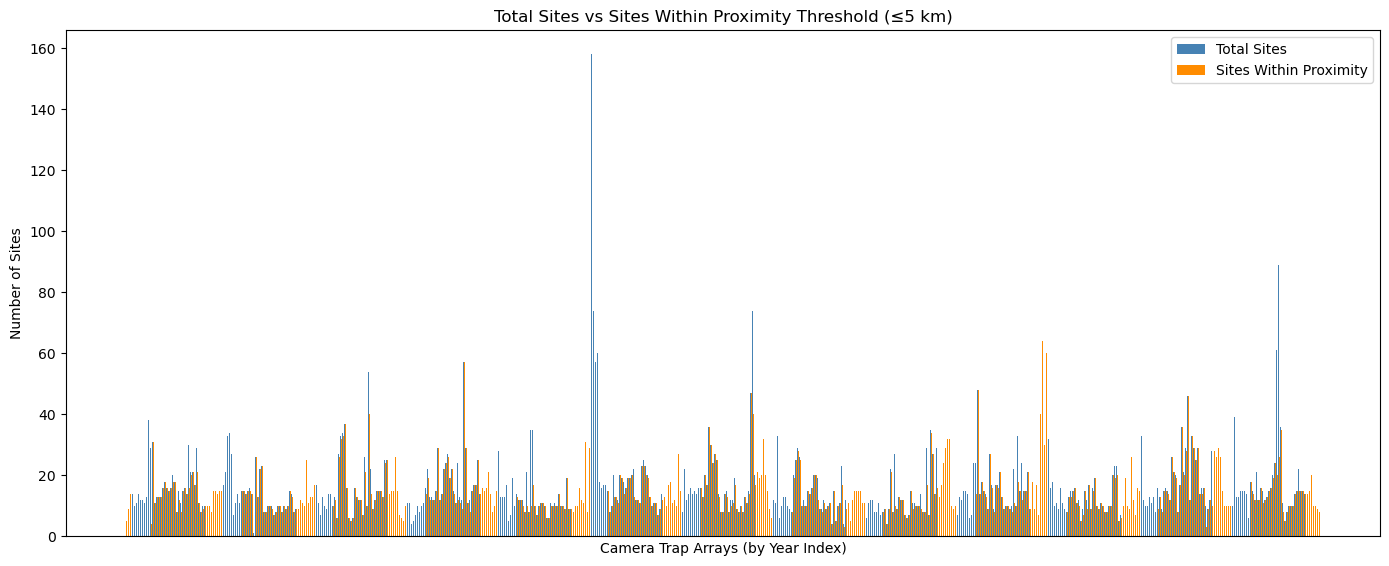

In [145]:
plt.figure(figsize=(14, 6))
x = range(len(array_distances_with_year_df))

plt.bar(x, array_distances_with_year_df['Total_Sites'], width=0.4, label='Total Sites', color='steelblue', align='center')
plt.bar([i + 0.4 for i in x], array_distances_with_year_df['Sites_Within_Proximity_Threshold'], width=0.4, label='Sites Within Proximity', color='darkorange', align='center')

plt.xlabel('Camera Trap Arrays (by Year Index)')
plt.ylabel('Number of Sites')
plt.title('Total Sites vs Sites Within Proximity Threshold (≤5 km)')
plt.legend()
plt.tight_layout()
plt.xticks([], [])  # Hide x-axis labels due to many entries
plt.show()

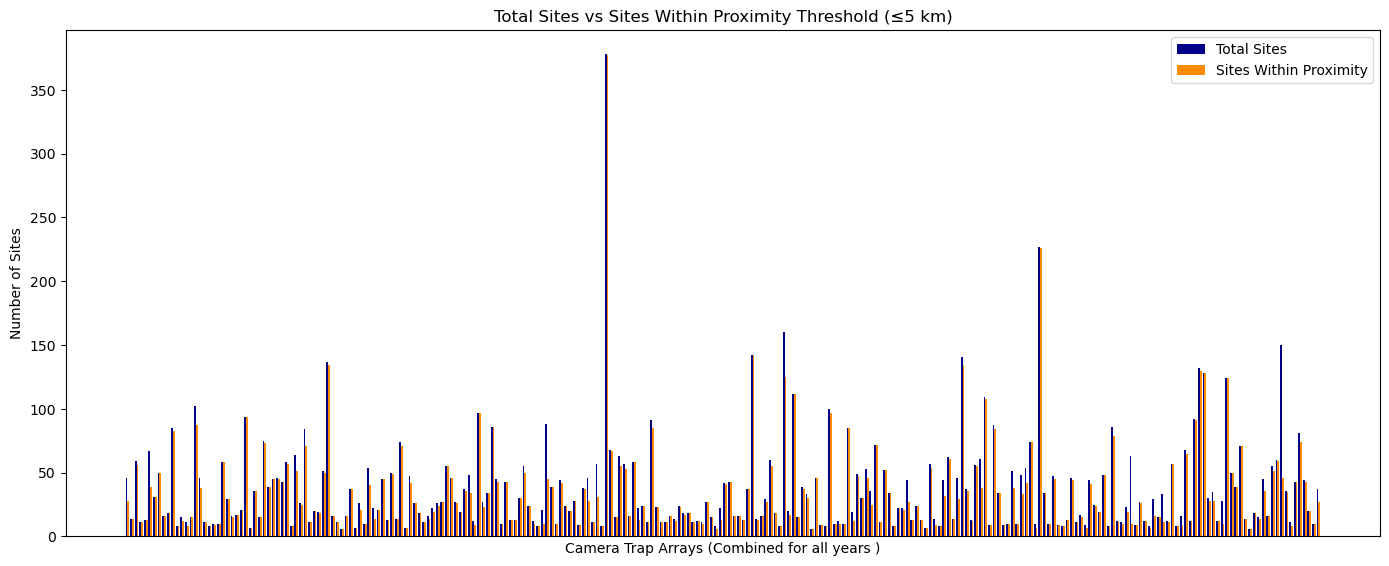

In [147]:
combined_df = array_distances_with_year_df.groupby('Camera_Trap_Array').agg({
    'Total_Sites': 'sum',  # assuming we want the max sites across years
    'Sites_Within_Proximity_Threshold': 'sum'
}).reset_index()

# Plot the combined values
plt.figure(figsize=(14, 6))
x = range(len(combined_df))

plt.bar(x, combined_df['Total_Sites'], width=0.4, label='Total Sites', color='darkblue', align='center')
plt.bar([i + 0.4 for i in x], combined_df['Sites_Within_Proximity_Threshold'], width=0.4, label='Sites Within Proximity', color='darkorange', align='center')


plt.xlabel('Camera Trap Arrays (Combined for all years )')
plt.ylabel('Number of Sites')
plt.title('Total Sites vs Sites Within Proximity Threshold (≤5 km)')
plt.legend()
plt.tight_layout()
plt.xticks([], [])  # Hide x-axis labels due to many entries
plt.show()

In [100]:
array_distances_with_year_df.head(10)

,Camera_Trap_Array,Year,Total_Sites,Mean_Latitude,Mean_Longitude,Min_Distance_km,Max_Distance_km,Sites_Within_Proximity_Threshold,Proximity_List
0,ARNWR,2020,9,35.8094,-75.9057,0.0000,14.4139,5,"{NC_Forest_Alligator_River_NWR_20_03, NC_Fores..."
1,ARNWR,2021,17,35.8236,-75.8931,0.0000,16.5962,9,"{NC_Wetland_ARNWR_21_dep_15, NC_Wetland_ARNWR_..."
2,ARNWR,2022,20,35.8263,-75.8911,0.0000,14.7088,14,"{NC_Wetland_ARNWR_22_Cam07, NC_Wetland_ARNWR_2..."
3,AandM,2022,14,26.2209,-97.4273,0.2470,2.0550,14,"{TX_Shrubland_A&M_CCR002, TX_Shrubland_A&M_CCR..."
4,Abilene,2019,10,32.2393,-99.8829,0.1615,1.7571,10,"{TX_Grassland_Abilene_13B, TX_Grassland_Abilen..."
5,Abilene,2020,11,32.2383,-99.8839,0.2311,2.6991,11,"{TX_Grassland_Abilene_20_05, TX_Grassland_Abil..."
6,Abilene,2021,14,32.2374,-99.8833,0.0000,2.2371,12,"{Abilene State Park Texas 6, Abilene State Par..."
7,Abilene,2022,12,32.2364,-99.8847,0.0000,2.7055,11,"{TX_Grassland_Abilene_22_3, TX_Grassland_Abile..."
8,Abilene,2023,12,32.2379,-99.8841,0.2207,2.7106,12,{TX_Grassland_Abilene State Park Texas 09/02/2...
9,AbitaFlats,2021,11,30.5128,-89.9678,0.2398,2.0776,11,"{LA_Forest_AbitaFlats_21_CS09, LA_Forest_Abita..."


In [17]:
output_path = out_dir + r'/camera_array_5km_proximity_sites.csv'
array_distances_with_year_df[['Camera_Trap_Array','Year','Mean_Latitude','Mean_Longitude', 'Proximity_List'] ].to_csv(output_path, index=False)
#output_path = out_dir + r'/proximity_sites/camera_array_5km_proximity_sites.csv'
#array_distances_with_year_df[['Camera_Trap_Array','Year', 'Mean_Latitude', 'Mean_Longitude','Proximity_List']].to_csv(output_path, index=False)


In [74]:
max_Max_Distance = array_distances_with_year_df['Max_Distance_km'].max()
print(max_Max_Distance)

530.0799187809421


In [75]:

max_distance_rows = array_distances_with_year_df[
    array_distances_with_year_df['Max_Distance_km'] == max_Max_Distance
]

# Output the result
print("Maximum Max_Distance_km:", max_Max_Distance)
print("Corresponding Array-Year Info:")
print(max_distance_rows)

Maximum Max_Distance_km: 530.0799187809421
Corresponding Array-Year Info:
   Camera_Trap_Array  Year  Total_Sites  Min_Distance_km  Max_Distance_km  \
12            Ahlers  2023           29         2.275119       530.079919   

    Sites_Within_Proximity_Threshold  
12                                 4  


In [76]:



max_distance_rows = array_distances_with_year_df[
    array_distances_with_year_df['Max_Distance_km'] >= camera_trap_dis_threshold
]

top_10_max_distance = max_distance_rows.sort_values(
    by=['Max_Distance_km', 'Camera_Trap_Array', 'Year'], 
    ascending=[False, True, True]
).head(50)


# Output the result
print("Total Rows for Camera Trap :" , array_distances_with_year_df.shape[0])
print("Unique Camera Traps  :" , array_distances_with_year_df['Camera_Trap_Array'].nunique())
print("For Camera Trap Array Sites Distance Threshold:", camera_trap_dis_threshold)
print("Corresponding Array-Year Info:")
print(top_10_max_distance)

print("Unique Camera Traps with max distance > threshold" , max_distance_rows['Camera_Trap_Array'].nunique())

Total Rows for Camera Trap : 591
Unique Camera Traps  : 262
For Camera Trap Array Sites Distance Threshold: 5
Corresponding Array-Year Info:
        Camera_Trap_Array  Year  Total_Sites  Min_Distance_km  \
12                 Ahlers  2023           29         2.275119   
170                 Elwha  2020           12         2.805482   
187              FortHays  2022           13         0.559493   
475            StLawrence  2020           12         0.000000   
13               Alamance  2019           31         0.186919   
534  UniversityofNebraska  2021           10         3.762309   
494                 Surry  2019           23         0.341560   
322                 Moore  2019           33         0.446165   
357      OlympicPeninsula  2022           15         2.316418   
149                  Dare  2019           22         0.000000   
333                   NYC  2023           26         0.198587   
431                   SLC  2023           17         0.000000   
23            

In [83]:
violations_df = array_distances_with_year_df[array_distances_with_year_df['Max_Distance_km'] > camera_trap_dis_threshold]

# Sort for inspection
violations_sorted = violations_df.sort_values(
    by=['Max_Distance_km', 'Camera_Trap_Array', 'Year'], 
    ascending=[False, True, True]
)
print(f'Number of Camera Trap Arrays with Max Dis > {camera_trap_dis_threshold} = {violations_df.shape[0]} ')
print(violations_sorted[['Camera_Trap_Array', 'Year', 'Sites_Within_Proximity_Threshold', 'Min_Distance_km', 'Max_Distance_km']])



Number of Camera Trap Arrays with Max Dis > 5 = 248 
    Camera_Trap_Array  Year  Sites_Within_Proximity_Threshold  \
12             Ahlers  2023                                 4   
170             Elwha  2020                                 8   
187          FortHays  2022                                13   
475        StLawrence  2020                                 9   
13           Alamance  2019                                31   
..                ...   ...                               ...   
363    OregonStateUni  2023                                15   
361    OregonStateUni  2021                                15   
18               Alto  2022                                16   
273          LaCopita  2023                                27   
180            Farris  2021                                14   

     Min_Distance_km  Max_Distance_km  
12          2.275119       530.079919  
170         2.805482        83.324200  
187         0.559493        56.507998  
475   

In [162]:
top_proximity_arrays_df = array_distances_with_year_df[array_distances_with_year_df['Max_Distance_km'] <= camera_trap_dis_threshold]

top_proximity_arrays_sorted = top_proximity_arrays_df.sort_values(
    by=['Sites_Within_Proximity_Threshold', 'Camera_Trap_Array', 'Year'], 
    ascending=[False, True, True]
)



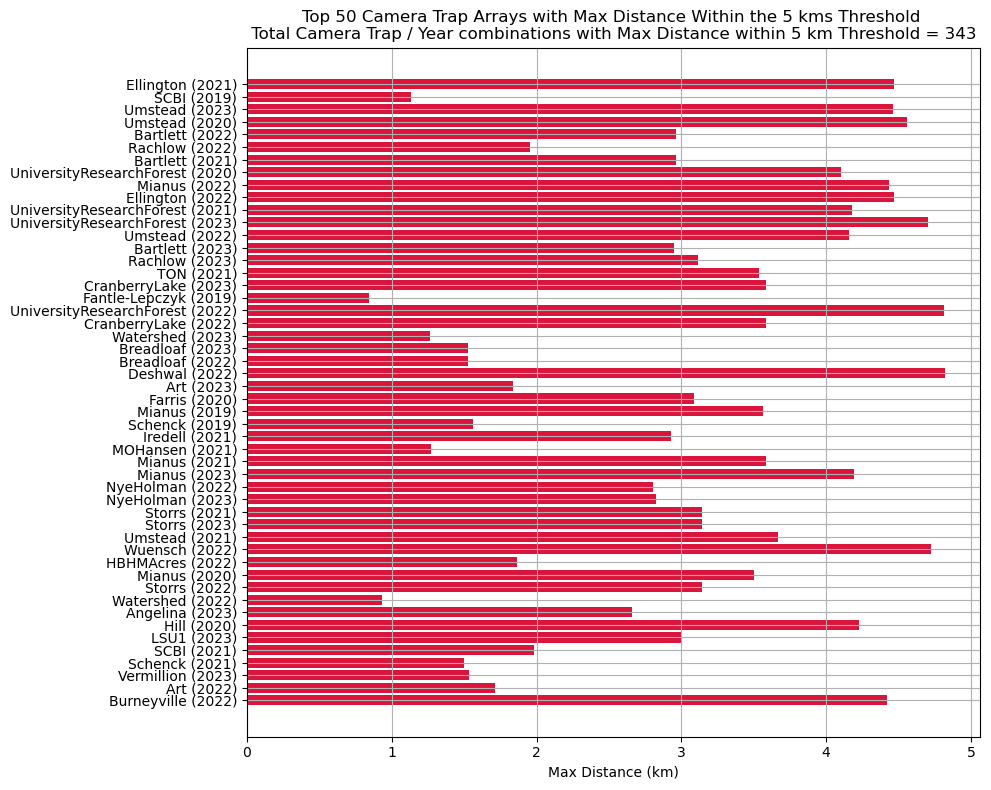

In [91]:
top_proximities = top_proximity_arrays_sorted.head(50)

plt.figure(figsize=(10, 8))
plt.barh(
    y=[f"{row['Camera_Trap_Array']} ({int(row['Year'])})" for _, row in top_proximities.iterrows()],
    width=top_proximities['Max_Distance_km'],
    color='crimson'
)
plt.xlabel("Max Distance (km)")
plt.title(f"Top 50 Camera Trap Arrays with Max Distance Within the {camera_trap_dis_threshold} kms Threshold \n Total Camera Trap / Year combinations with Max Distance within 5 km Threshold = 343 ")

plt.gca().invert_yaxis()  # Highest at the top
plt.tight_layout()
plt.grid(True)
plt.show()

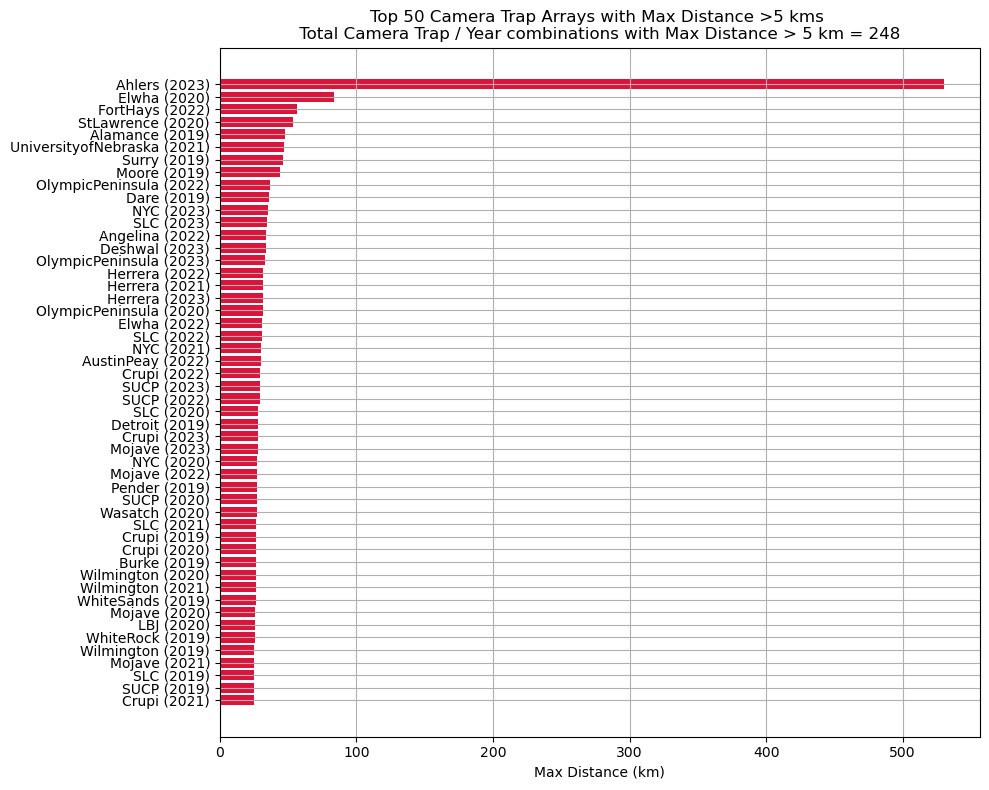

In [94]:
top_n = violations_df.shape[0]  # adjust as needed
top_violations = violations_sorted.head(50)

plt.figure(figsize=(10, 8))
plt.barh(
    y=[f"{row['Camera_Trap_Array']} ({int(row['Year'])})" for _, row in top_violations.iterrows()],
    width=top_violations['Max_Distance_km'],
    color='crimson'
)
plt.xlabel("Max Distance (km)")
plt.title(f"Top 50 Camera Trap Arrays with Max Distance >{camera_trap_dis_threshold} kms \n Total Camera Trap / Year combinations with Max Distance > 5 km = 248 ")
plt.gca().invert_yaxis()  # Highest at the top
plt.tight_layout()
plt.grid(True)
plt.show()

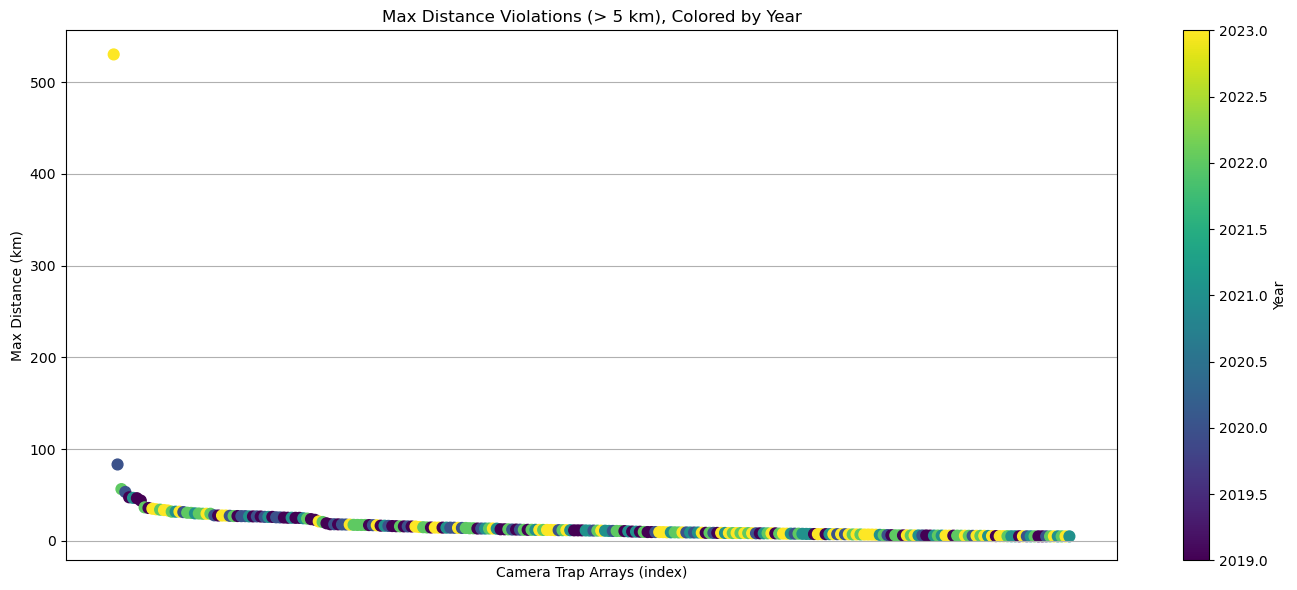

In [50]:
# Plot scatter without x-axis labels
plt.figure(figsize=(14, 6))
scatter = plt.scatter(
    x=range(len(violations_sorted)),
    y=violations_sorted['Max_Distance_km'],
    c=violations_sorted['Year'],
    cmap='viridis',
    s=60
)
plt.colorbar(scatter, label='Year')
plt.xticks([])  # Hide x-axis labels for clarity
plt.xlabel("Camera Trap Arrays (index)")
plt.ylabel("Max Distance (km)")
plt.title("Max Distance Violations (> 5 km), Colored by Year")
plt.tight_layout()
plt.grid(True)
plt.show()

### Find Camera Trap Arrays that have complete data 

In [164]:
array_distances_with_year_df.head()

,Camera_Trap_Array,Year,Total_Sites,Mean_Latitude,Mean_Longitude,Min_Distance_km,Max_Distance_km,Sites_Within_Proximity_Threshold,Proximity_List
0,ARNWR,2020,9,35.8094,-75.9057,0.0000,14.4139,5,"{NC_Forest_Alligator_River_NWR_20_03, NC_Fores..."
1,ARNWR,2021,17,35.8236,-75.8931,0.0000,16.5962,9,"{NC_Wetland_ARNWR_21_dep_15, NC_Wetland_ARNWR_..."
2,ARNWR,2022,20,35.8263,-75.8911,0.0000,14.7088,14,"{NC_Wetland_ARNWR_22_Cam07, NC_Wetland_ARNWR_2..."
3,AandM,2022,14,26.2209,-97.4273,0.2470,2.0550,14,"{TX_Shrubland_A&M_CCR002, TX_Shrubland_A&M_CCR..."
4,Abilene,2019,10,32.2393,-99.8829,0.1615,1.7571,10,"{TX_Grassland_Abilene_13B, TX_Grassland_Abilen..."


In [220]:
years_required = set(range(2019, 2024))
print("Required Years List", years_required)

# collect sets of years for each camera trap array
camera_arrays_with_years = array_distances_with_year_df.groupby('Camera_Trap_Array')['Year'].apply(set)

camera_arrays_all_years = camera_arrays_with_years[camera_arrays_with_years.apply(
    lambda years: years_required.issubset(years))
]

arrays_with_all_years_list = camera_arrays_all_years.index.tolist()
len(arrays_with_all_years_list)

Required Years List {2019, 2020, 2021, 2022, 2023}


43

In [221]:
#arrays_all_years_data = array_distances_with_year_df[array_distances_with_year_df['Camera_Trap_Array'].isin(arrays_with_all_years_list)]
arrays_all_years_data_df = array_distances_with_year_df[array_distances_with_year_df['Camera_Trap_Array'].isin(arrays_with_all_years_list)]

In [222]:
arrays_all_years_data_df['Camera_Trap_Array'].nunique()

43

In [223]:
arrays_all_years_data_df['Sites_Within_Proximity_Threshold'].sum()

np.int64(3656)

In [209]:
arrays_all_years_data_df = arrays_all_years_data_df.rename(columns={
    'Camera_Trap_Array': 'Array_Id',
    'Year': 'Year',
    'Proximity_List': 'Nearby_Deployment_IDs'
})

In [80]:
output_path = out_dir + r'/camera_array_5km_proximity_all_years.csv'
arrays_all_years_data_df[['Array_Id','Year','Nearby_Deployment_IDs'] ].to_csv(output_path, index=False)